In [ ]:
#Shabdanbek Nurassyl-scraping
#Bekkozha Ayana-analysing
#Kazakhbay Madina-analysing
#Yestibay Sultan-cleaning
#Nurken Yeraly-vizualization
#Askerbekov Aliyar-cleaning
!pip install requests beautifulsoup4 lxml openpyxl

import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import time

# -------- Настройки --------

headers = {
    "User-Agent": (
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
        "AppleWebKit/537.36 (KHTML, like Gecko) "
        "Chrome/120.0.0.0 Safari/537.36"
    )
}

price_re = re.compile(r"\d[\d\s]+₸")

# Крупные каталоги Lamoda (можешь добавить ещё)
categories = {
    "women":  "https://www.lamoda.kz/c/4153/default-women/?page={page}",
    "men":    "https://www.lamoda.kz/c/4152/default-men/?page={page}",
    "kids":   "https://www.lamoda.kz/c/4154/default-kids/?page={page}",
    "beauty": "https://www.lamoda.kz/c/4308/default-krasotawoman/?page={page}",
    "home":   "https://www.lamoda.kz/c/6647/home_accs-tovarydlyadoma/?page={page}",
}

max_pages_per_category = 500      # максимум страниц на одну категорию
target_products = 100_000         # хотим набрать хотя бы столько товаров


# -------- Парсим одну страницу каталога --------

def parse_listing_page(url, category_name):
    try:
        resp = requests.get(url, headers=headers, timeout=15)
    except Exception as e:
        print(f"[{category_name}] Ошибка запроса {url}: {e}")
        return []

    if resp.status_code != 200:
        print(f"[{category_name}] status {resp.status_code} для {url}")
        return []

    soup = BeautifulSoup(resp.text, "lxml")
    full_text = soup.get_text("\n", strip=True)
    lines = [ln for ln in full_text.split("\n") if ln.strip()]

    rows = []
    i = 0

    while i < len(lines) - 2:
        line = lines[i]

        if price_re.search(line):
            price = line
            brand = lines[i + 1] if i + 1 < len(lines) else ""
            name  = lines[i + 2] if i + 2 < len(lines) else ""

            rows.append({
                "Category": category_name,
                "Price": price,
                "Brand": brand,
                "Name": name,
                "PageURL": url
            })

            i += 3
        else:
            i += 1

    print(f"[{category_name}] {url} — товаров: {len(rows)}")
    return rows


# -------- Обходим категории/страницы, пока не наберём ~100k --------

all_rows = []

stop_everything = False

for cat_name, base_url in categories.items():
    if stop_everything:
        break

    print(f"\n===== КАТЕГОРИЯ: {cat_name} =====")
    page = 1

    while page <= max_pages_per_category:
        if stop_everything:
            break

        url = base_url.format(page=page)
        print(f"[{cat_name}] страница {page}")

        rows = parse_listing_page(url, cat_name)

        # если на странице уже нет товаров — выходим из этой категории
        if not rows:
            print(f"[{cat_name}] товаров на page={page} нет — стоп по категории")
            break

        all_rows.extend(rows)

        # если набрали нужное количество — стоп вообще
        if len(all_rows) >= target_products:
            print(f"\nДостигнут лимит {target_products} товаров — останавливаем сбор.")
            stop_everything = True
            break

        page += 1
        time.sleep(1)   # пауза, чтобы не душить сайт

print("\nВСЕГО ТОВАРОВ СОБРАНО:", len(all_rows))

# -------- Таблица + сохранение в Excel --------

df = pd.DataFrame(all_rows, columns=["Category", "Price", "Brand", "Name", "PageURL"])

print("Размер таблицы:", df.shape)

file_name = "lamoda_all_products_m.xlsx"
df.to_excel(file_name, index=False)
print("Файл Excel сохранён как:", file_name)

df.head(30)



===== КАТЕГОРИЯ: women =====
[women] страница 1
[women] https://www.lamoda.kz/c/4153/default-women/?page=1 — товаров: 60
[women] страница 2
[women] https://www.lamoda.kz/c/4153/default-women/?page=2 — товаров: 60
[women] страница 3
[women] https://www.lamoda.kz/c/4153/default-women/?page=3 — товаров: 60
[women] страница 4
[women] https://www.lamoda.kz/c/4153/default-women/?page=4 — товаров: 60
[women] страница 5
[women] https://www.lamoda.kz/c/4153/default-women/?page=5 — товаров: 60
[women] страница 6
[women] https://www.lamoda.kz/c/4153/default-women/?page=6 — товаров: 60
[women] страница 7
[women] https://www.lamoda.kz/c/4153/default-women/?page=7 — товаров: 60
[women] страница 8
[women] https://www.lamoda.kz/c/4153/default-women/?page=8 — товаров: 60
[women] страница 9
[women] https://www.lamoda.kz/c/4153/default-women/?page=9 — товаров: 60
[women] страница 10
[women] https://www.lamoda.kz/c/4153/default-women/?page=10 — товаров: 60
[women] страница 11
[women] https://www.lamoda.k

,Category,Price,Brand,Name,PageURL
0,women,2 177 ₸,Matrix Sport,Топ спортивный,https://www.lamoda.kz/c/4153/default-women/?pa...
1,women,2 974 ₸,De Mount,Термокружка,https://www.lamoda.kz/c/4153/default-women/?pa...
2,women,4 934 ₸,Matrix Sport,Трусы 7 шт.,https://www.lamoda.kz/c/4153/default-women/?pa...
3,women,8 129 ₸,Vivian Royal,Туфли,https://www.lamoda.kz/c/4153/default-women/?pa...
4,women,7 802 ₸,Zarina,Лонгслив,https://www.lamoda.kz/c/4153/default-women/?pa...
5,women,2 794 ₸,Vivienne Sabo,Тушь для ресниц,https://www.lamoda.kz/c/4153/default-women/?pa...
6,women,7 327 ₸,Zarina,Свитер,https://www.lamoda.kz/c/4153/default-women/?pa...
7,women,8 990 ₸,Settimo Senso,Платье,https://www.lamoda.kz/c/4153/default-women/?pa...
8,women,14 997 ₸,Nectar Lingerie,Юбка,https://www.lamoda.kz/c/4153/default-women/?pa...
9,women,10 396 ₸,Zarina,Брюки,https://www.lamoda.kz/c/4153/default-women/?pa...


In [ ]:
import pandas as pd
import re

FILE_PATH = "/content/lamoda_all_products_m.xlsx"

df = pd.read_excel(FILE_PATH)

def parse_price(price_str):
    if pd.isna(price_str):
        return None

    s = str(price_str)

    # Удаляем всё кроме цифр — лучший универсальный вариант
    digits = re.sub(r"[^\d]", "", s)

    if digits == "":
        return None

    return int(digits)

# применяем функцию
df["Price_num"] = df["Price"].apply(parse_price)

df[["Price", "Price_num"]].head(20)


,Price,Price_num
0,2 177 ₸,2177
1,2 974 ₸,2974
2,4 934 ₸,4934
3,8 129 ₸,8129
4,7 802 ₸,7802
5,2 794 ₸,2794
6,7 327 ₸,7327
7,8 990 ₸,8990
8,14 997 ₸,14997
9,10 396 ₸,10396


In [ ]:
!pip install openpyxl

import pandas as pd
from openpyxl import load_workbook

file_path = 'lamoda_all_products_m.xlsx'   # твой файл

# 1. Читаем данные (первый лист)
df = pd.read_excel(file_path, sheet_name=0)

# 2. Считаем, сколько товаров у каждого бренда
brand_counts = df['Brand'].value_counts()

# берём топ-50 брендов по количеству товаров
top_brands = brand_counts.head(50).index.tolist()
print("Топ-50 брендов по количеству товаров:")
print(brand_counts.head(50))

# 3. Функция для безопасного имени листа
def make_sheet_name(name, used_names):
    s = str(name)
    if s.strip() == '':
        s = 'NO_BRAND'

    # запрещённые символы Excel
    for ch in '[]:*?/\\':
        s = s.replace(ch, '_')

    # максимум 31 символ
    s = s[:31]

    # избегаем дубликатов имён
    base = s
    i = 1
    while s in used_names:
        suffix = f"_{i}"
        s = base[: (31 - len(suffix))] + suffix
        i += 1

    used_names.add(s)
    return s

# 4. Уже существующие листы
book = load_workbook(file_path)
used_names = set(book.sheetnames)

# 5. Создаём листы только для топ-50 брендов
with pd.ExcelWriter(file_path, engine='openpyxl', mode='a', if_sheet_exists='overlay') as writer:
    for brand in top_brands:
        sheet_name = make_sheet_name(brand, used_names)
        df_brand = df[df['Brand'] == brand]

        print(f'Создаём лист: {sheet_name} (товаров: {len(df_brand)})')
        df_brand.to_excel(writer, sheet_name=sheet_name, index=False)

print('Готово! Созданы листы только для ТОП-50 брендов.')


Топ-50 брендов по количеству товаров:
Brand
Sela                    5275
adidas                  4501
PlayToday               3883
PUMA                    3542
Vans                    2569
Baon                    2371
Reebok                  1916
Tom Tailor              1648
Mango Kids              1605
Tommy Hilfiger          1557
Zarina                  1476
Geox                    1472
Acoola                  1405
Befree                  1292
Dino Ricci              1246
Outventure              1076
Francesco Donni         1059
Lamoda Home              945
adidas Originals         944
Nike                     917
12 STOREEZ               853
Guess                    842
Jack & Jones             796
Incanto                  791
Mossmore                 790
Karl Lagerfeld Jeans     759
Bossa Nova               753
Boss                     748
Winterra                 737
Fila                     731
Mia Gia                  720
Timberland               716
Milana                   713

In [ ]:
import pandas as pd

# 1. Если файл уже загружен в Colab (в /content)
file_path = "lamoda_all_products_m.xlsx"

# 2. Читаем Excel
df = pd.read_excel(file_path)

# 3. Делаем из столбца Price нормальные числа
df["Price_num"] = (
    df["Price"]
    .astype(str)
    .str.replace(r"\s+", "", regex=True)   # убираем пробелы "3 367 400"
    .str.replace("₸", "", regex=False)     # убираем знак тенге
    .str.replace(",", ".", regex=False)    # на всякий случай, если есть запятая
    .astype(float)
)

# 4. Находим максимальную цену
max_price = df["Price_num"].max()

# 5. Строки с максимальной ценой (вдруг несколько товаров)
max_rows = df[df["Price_num"] == max_price]

print("Самая большая цена:", max_price, "₸")
print("\nТовары с этой ценой:")
print(max_rows[["Category", "Brand", "Name", "Price"]])

from IPython.display import Image, display

url = "https://a.lmcdn.ru/img600x866/R/T/RTLAET633701_30491200_1_v1_2x.jpg"

display(Image(url=url))


Самая большая цена: 3367400.0 ₸

Товары с этой ценой:
      Category         Brand      Name        Price
33734      men  Stone Island  Дубленка  3 367 400 ₸


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
df.head()

,Category,Price,Brand,Name,PageURL,Price_num
0,women,2177,Matrix Sport,Топ спортивный,https://www.lamoda.kz/c/4153/default-women/?pa...,2177
1,women,2974,De Mount,Термокружка,https://www.lamoda.kz/c/4153/default-women/?pa...,2974
2,women,4934,Matrix Sport,Трусы 7 шт.,https://www.lamoda.kz/c/4153/default-women/?pa...,4934
3,women,8129,Vivian Royal,Туфли,https://www.lamoda.kz/c/4153/default-women/?pa...,8129
4,women,7802,Zarina,Лонгслив,https://www.lamoda.kz/c/4153/default-women/?pa...,7802


In [ ]:
df.columns

Index(['Category', 'Price', 'Brand', 'Name', 'PageURL', 'Price_num'], dtype='object')

In [ ]:
df.describe()

,Price,Price_num
count,1.000200e+05,1.000200e+05
mean,5.316233e+04,5.316233e+04
std,5.869089e+04,5.869089e+04
min,9.590000e+02,9.590000e+02
25%,1.799000e+04,1.799000e+04
50%,3.140000e+04,3.140000e+04
75%,6.576000e+04,6.576000e+04
max,3.367400e+06,3.367400e+06


In [ ]:
df.shape

(100020, 6)

In [ ]:
df.isna().sum()

,0
Category,0
Price,0
Brand,0
Name,0
PageURL,0
Price_num,0


Text(20.847222222222214, 0.5, 'Number of Products')

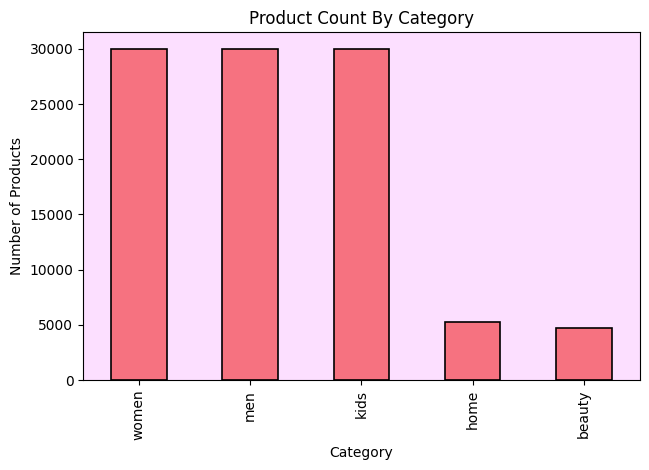

<Figure size 10000x6000 with 0 Axes>

In [ ]:
ax = df['Category'].value_counts() \
 .head(10) \
 .plot(kind='bar', title='Product Count By Category', color='#F67280', edgecolor='black', linewidth=1.2) \

ax.set_facecolor('#fcdfff')
plt.gcf().set_facecolor('white')
plt.tight_layout()
plt.figure(figsize=(100,60))
ax.set_xlabel('Category', color='black')
ax.set_ylabel('Number of Products', color='black')

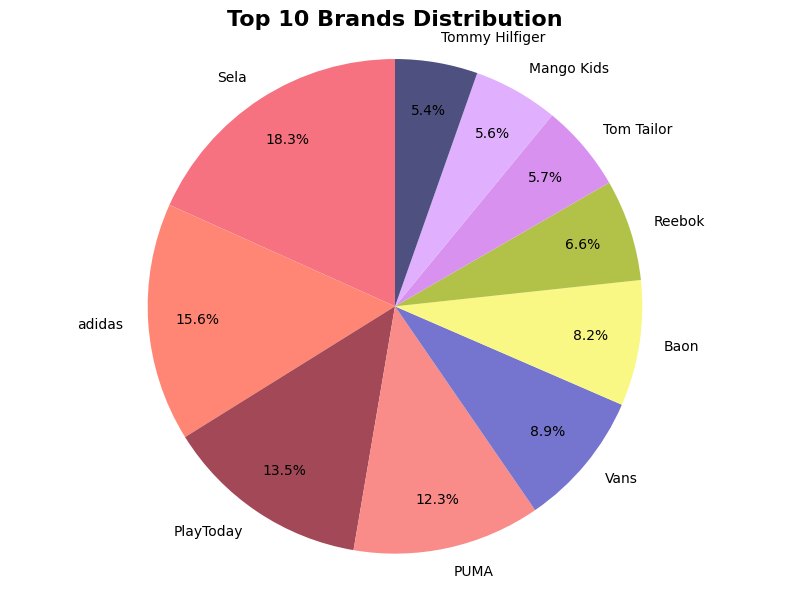

In [ ]:
top_brands=df['Brand'].value_counts().head(10)
plt.figure(figsize=(8,6))
colors=['#F67280', '#FF8674', '#A24857', '#F98B88', '#7575CF', '#FAF884', '#B2C248', '#D891EF', '#E0B0FF', '#4E5180']
plt.pie(
    top_brands,
    labels=top_brands.index,
    autopct='%1.1f%%',
    startangle=90,
    pctdistance=0.8,
    labeldistance=1.1,
    colors=colors
)
plt.title('Top 10 Brands Distribution', fontsize=16, fontweight='bold')
plt.axis('equal')
plt.tight_layout()
plt.show()

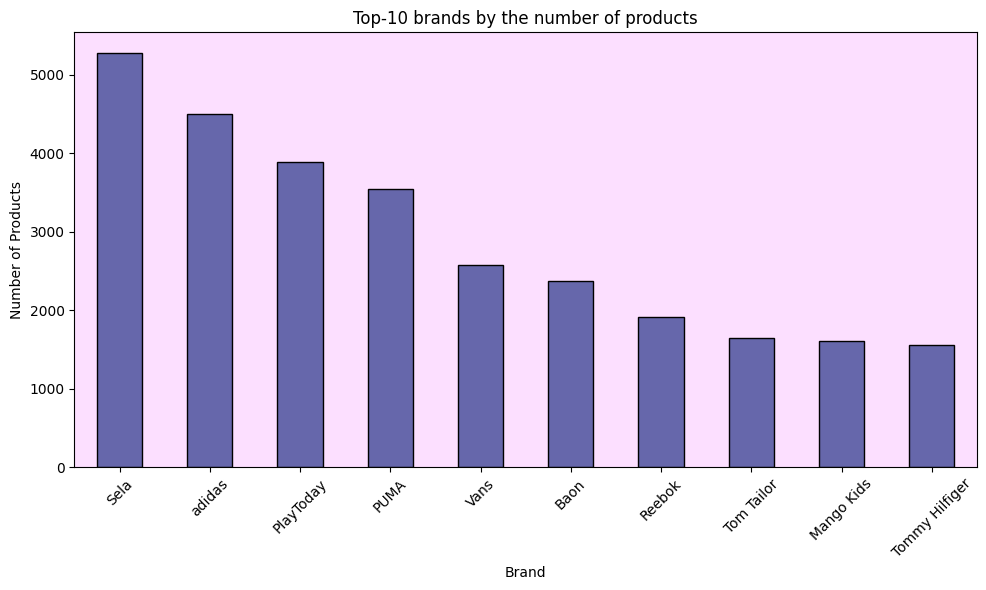

In [ ]:
top_brands = df['Brand'].value_counts().head(10)

plt.figure(figsize=(10, 6))
ax=plt.gca()
ax.set_facecolor('#fcdfff')
top_brands.plot(kind='bar', color='#6667AB', edgecolor='black')
plt.title('Top-10 brands by the number of products')
plt.xlabel('Brand', color='black')
plt.ylabel('Number of Products', color='black')
plt.xticks(rotation=45, color='black')
plt.tight_layout()
ax.grid(False)
plt.show()

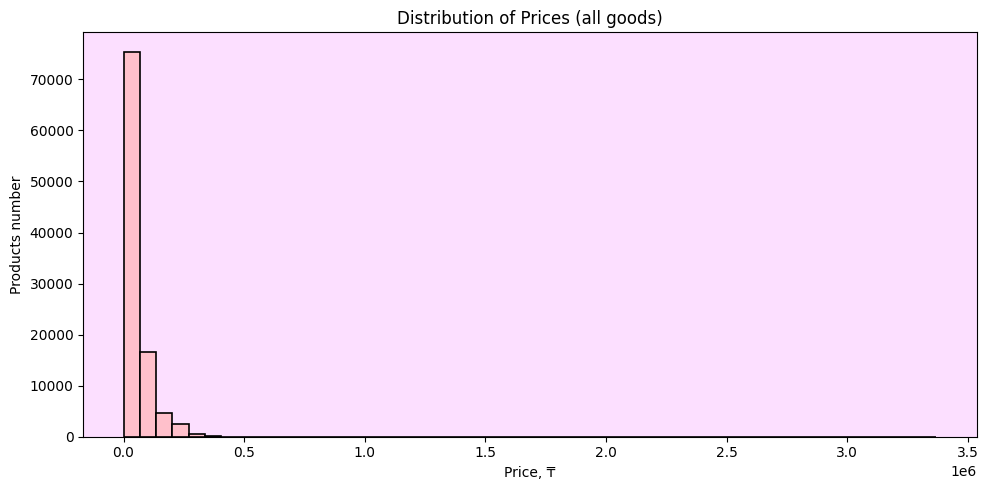

In [ ]:
import re
import pandas as pd
import matplotlib.pyplot as plt

# Проверим, есть ли колонка Price_num, если нет — создаём
if "Price_num" not in df.columns:
    def parse_price(price_str):
        if pd.isna(price_str):
            return None
        s = str(price_str)
        # убираем всё кроме цифр
        digits = re.sub(r"[^\d]", "", s)
        if digits == "":
            return None
        return int(digits)

    df["Price_num"] = df["Price"].apply(parse_price)

# Теперь строим гистограмму
prices = pd.to_numeric(df["Price_num"], errors="coerce").dropna()

fig, ax = plt.subplots(figsize=(10, 5))
ax.set_facecolor("#fcdfff")
ax.hist(prices, bins=50, color="pink", edgecolor="black", linewidth=1.2)

ax.set_title("Distribution of Prices (all goods)")
ax.set_xlabel("Price, ₸", color="black")
ax.set_ylabel("Products number", color="black")

plt.tight_layout()
plt.show()


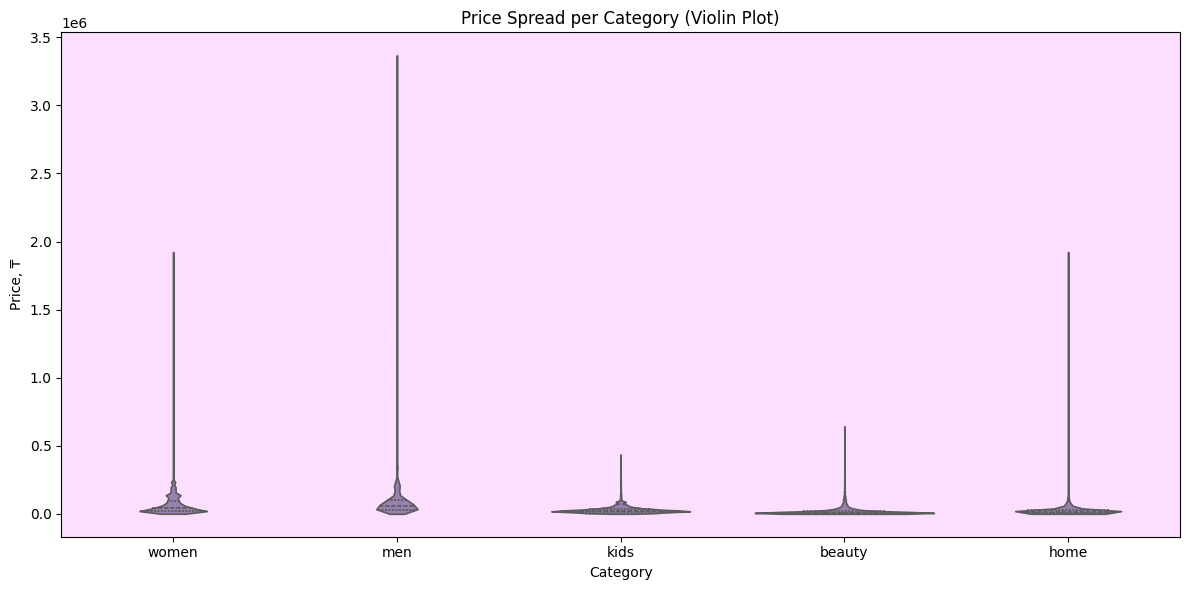

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re

# --- Проверяем Price_num и создаём если нужно ---
if "Price_num" not in df.columns:
    def parse_price(price_str):
        if pd.isna(price_str):
            return None
        s = str(price_str)
        digits = re.sub(r"[^\d]", "", s)
        if digits == "":
            return None
        return int(digits)
    df["Price_num"] = df["Price"].apply(parse_price)

# --- Чистим данные ---
df_clean = df.dropna(subset=["Category", "Price_num"]).copy()
df_clean["Price_num"] = pd.to_numeric(df_clean["Price_num"], errors="coerce")
df_clean = df_clean.dropna(subset=["Price_num"])

# --- Строим график ---
plt.figure(figsize=(12, 6))
ax = plt.gca()
ax.set_facecolor("#fcdfff")

sns.violinplot(
    data=df_clean,
    x="Category",
    y="Price_num",
    cut=0,
    inner="quartile",
    color="#967BB6"
)

plt.title("Price Spread per Category (Violin Plot)")
plt.xlabel("Category")
plt.ylabel("Price, ₸")

plt.tight_layout()
plt.show()



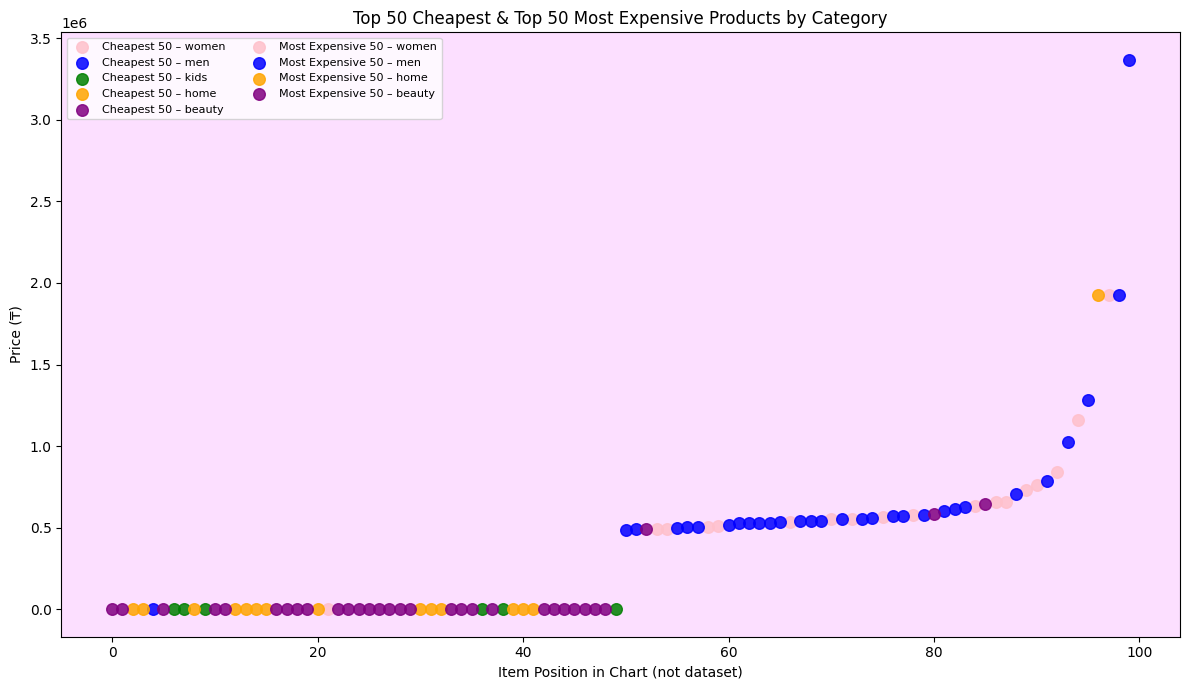

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

# --- 1. Гарантируем, что есть Price_num ---
if "Price_num" not in df.columns:
    def parse_price(price_str):
        if pd.isna(price_str):
            return None
        s = str(price_str)
        digits = re.sub(r"[^\d]", "", s)
        if digits == "":
            return None
        return int(digits)

    df["Price_num"] = df["Price"].apply(parse_price)

# --- 2. Чистим данные для графика ---
df_clean = df.dropna(subset=["Category", "Price_num"]).copy()
df_clean["Price_num"] = pd.to_numeric(df_clean["Price_num"], errors="coerce")
df_clean = df_clean.dropna(subset=["Price_num"])

# --- 3. Сортируем и берём 50 самых дешёвых / дорогих ---
df_sorted = df_clean.sort_values(by="Price_num")

cheap50 = df_sorted.head(50).copy()
expensive50 = df_sorted.tail(50).copy()

cheap50["x"] = np.arange(50)
expensive50["x"] = np.arange(50, 100)

category_colors = {
    "women": "pink",
    "men": "blue",
    "kids": "green",
    "home": "orange",
    "beauty": "purple"
}

plt.figure(figsize=(12, 7))
ax = plt.gca()
ax.set_facecolor("#fcdfff")

# чтобы не дублировать легенду
used_labels = set()

def plot_group(group, group_label):
    for cat, color in category_colors.items():
        subset = group[group["Category"] == cat]
        if subset.empty:
            continue
        label = f"{group_label} – {cat}"
        # добавляем в легенду только один раз
        if label in used_labels:
            label_to_use = None
        else:
            label_to_use = label
            used_labels.add(label)
        ax.scatter(
            subset["x"],
            subset["Price_num"],
            c=color,
            s=70,
            alpha=0.85,
            label=label_to_use
        )

plot_group(cheap50, "Cheapest 50")
plot_group(expensive50, "Most Expensive 50")

plt.xlabel("Item Position in Chart (not dataset)")
plt.ylabel("Price (₸)")
plt.title("Top 50 Cheapest & Top 50 Most Expensive Products by Category")
plt.legend(fontsize=8, ncol=2)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# ===== 1. Вводные файлы =====
INPUT_FILE = "lamoda_all_products_m.xlsx"      # исходный файл
OUTPUT_FILE = "lamoda_all_products_fin.xlsx"   # файл без дублей

# Если файл не в текущей папке, пропиши полный путь, например:
# INPUT_FILE = "/var/lamoda_all_products_m.xlsx"

# ===== 2. Загрузка =====
df = pd.read_excel(INPUT_FILE)

print("Строк до удаления дублей:", len(df))

# ===== 3. Удаляем дубликаты по всем колонкам =====
df_no_dups = df.drop_duplicates()

print("Строк после удаления дублей:", len(df_no_dups))
print("Удалено дублей:", len(df) - len(df_no_dups))

# Если нужно удалять дубли только по одному столбцу (например, URL товара),
# используй вместо строки выше вот так:
# df_no_dups = df.drop_duplicates(subset=["PageURL"])

# ===== 4. Сохраняем результат =====
df_no_dups.to_excel(OUTPUT_FILE, index=False)
print(f"Файл сохранён как: {OUTPUT_FILE}")


Строк до удаления дублей: 100020
Строк после удаления дублей: 99172
Удалено дублей: 848
Файл сохранён как: lamoda_all_products_fin.xlsx


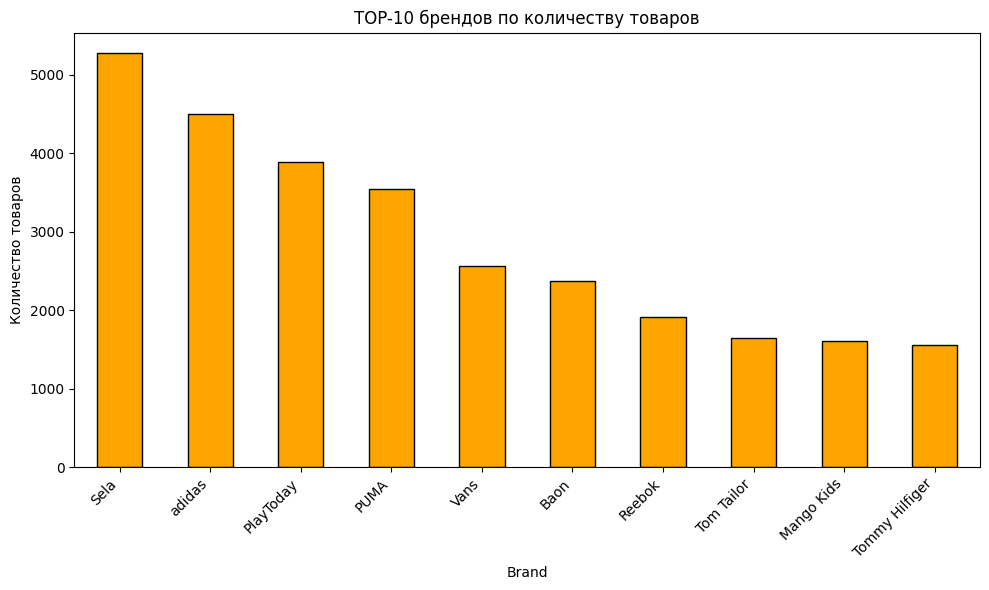

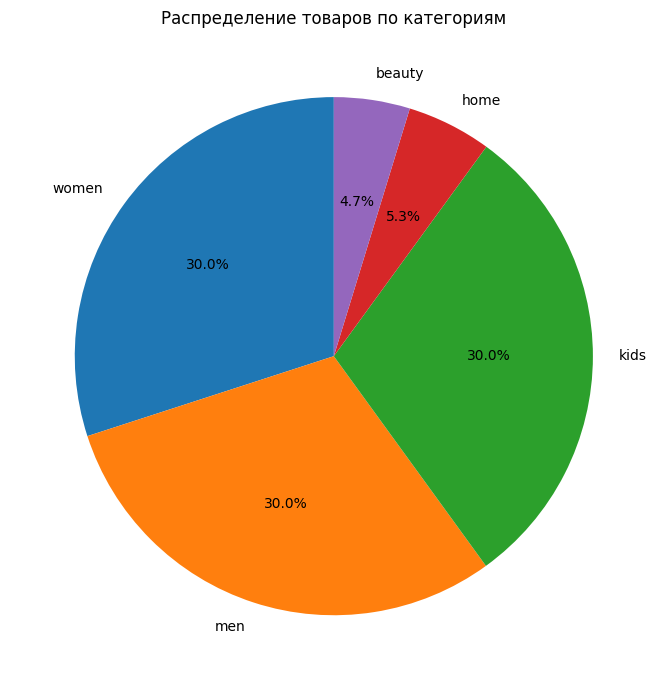

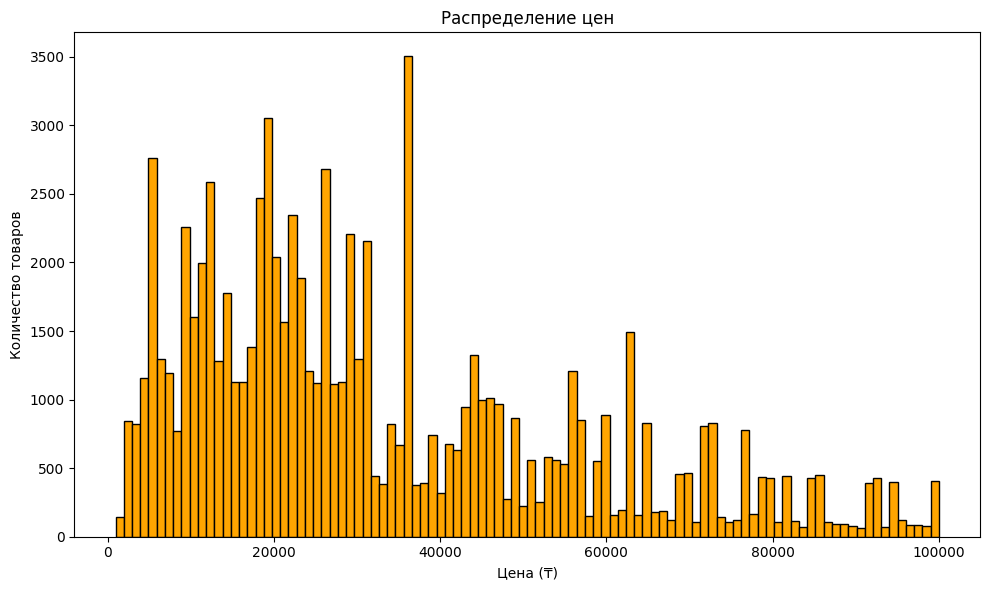

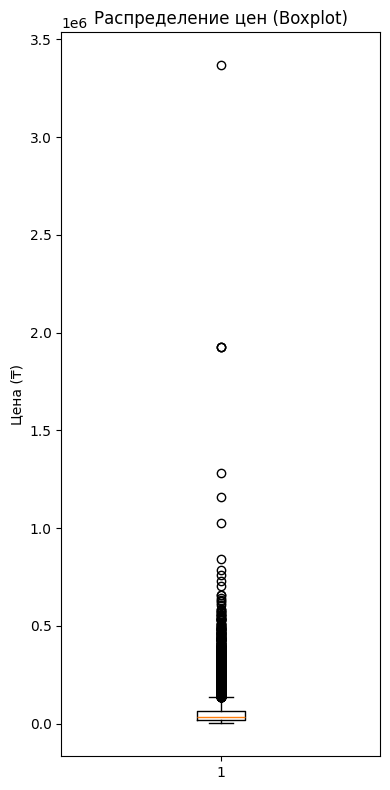

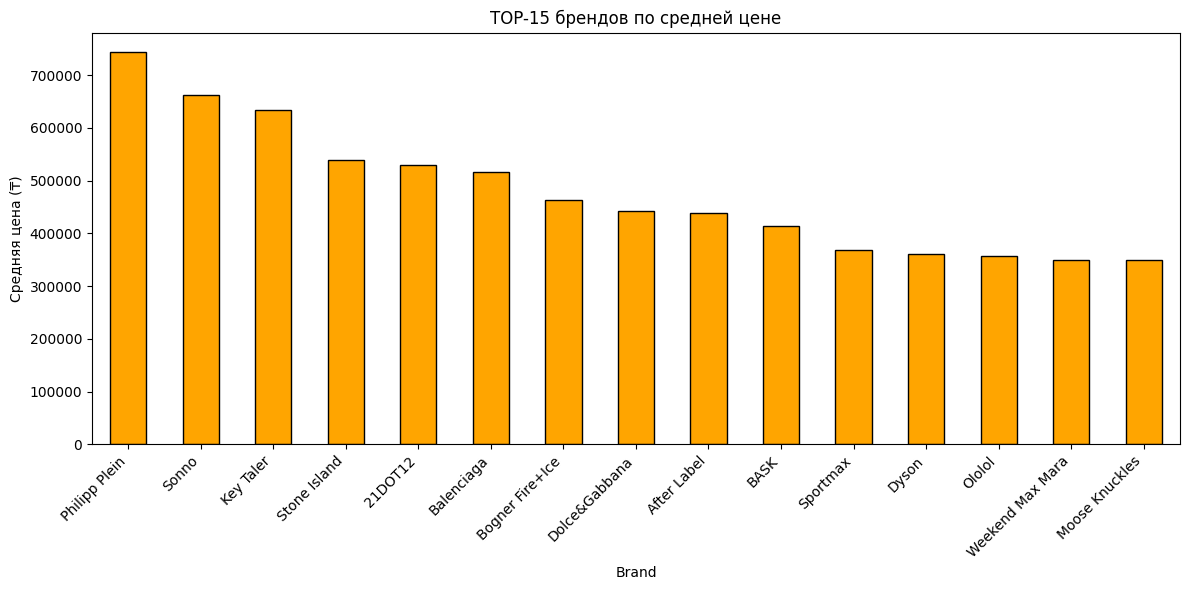

/tmp/ipython-input-336585927.py:132: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=labels_to_plot, showfliers=True)


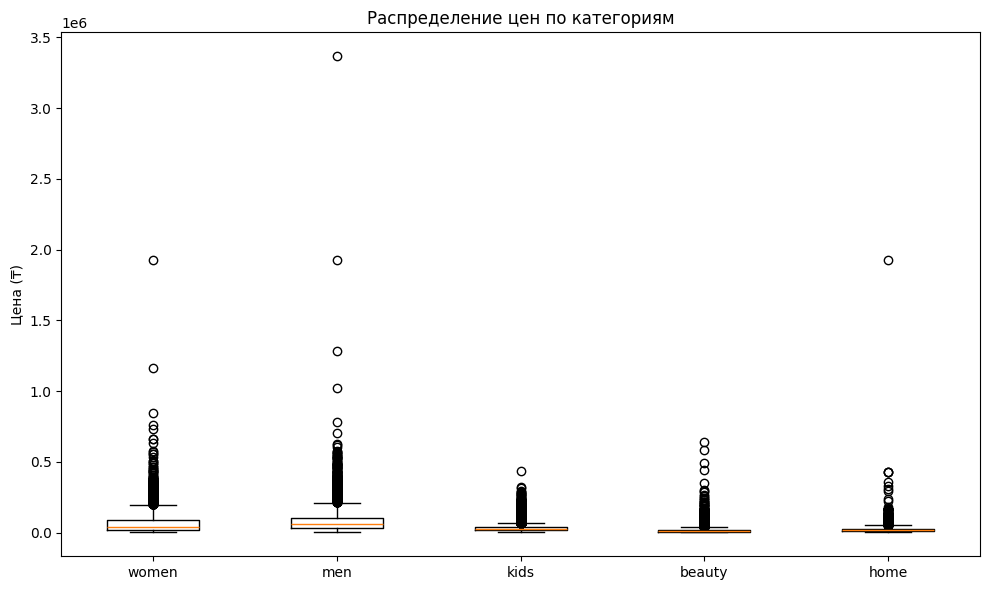

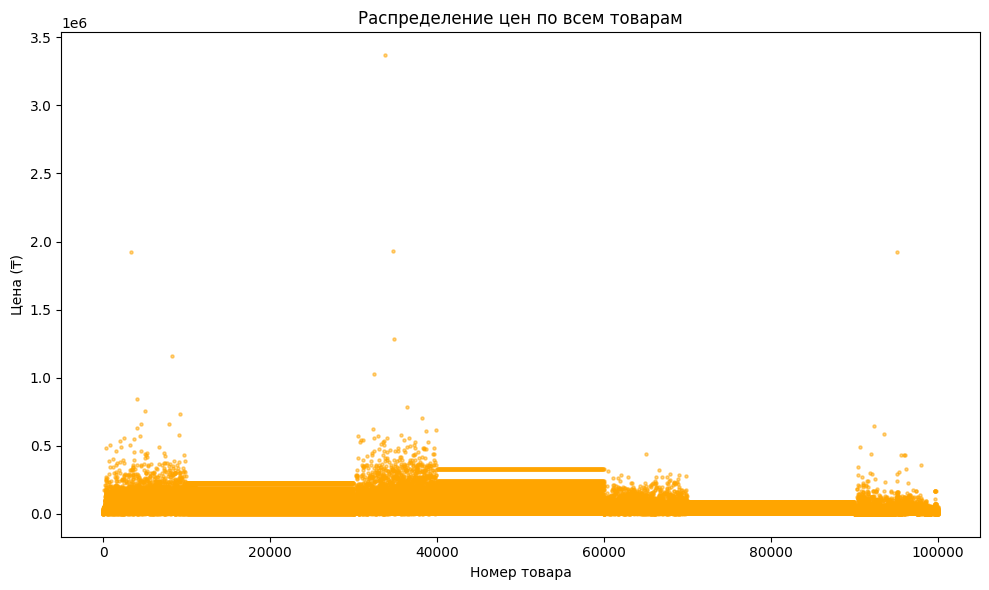

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------
# 1. Загрузка данных
# -----------------------------
file_path = "/content/lamoda_all_products_m.xlsx"
df = pd.read_excel(file_path)

# === ПРАВИЛЬНЫЕ НАЗВАНИЯ КОЛОНОК ===
COL_BRAND = "Brand"
COL_CATEGORY = "Category"
COL_PRICE = "Price"

# проверка колонок
for col in [COL_BRAND, COL_CATEGORY, COL_PRICE]:
    if col not in df.columns:
        raise ValueError(
            f"Колонки '{col}' нет в Excel. Твои колонки: {list(df.columns)}"
        )

# -----------------------------
# 2. Очистка и предобработка данных
# -----------------------------

# Преобразуем Price в строку и удалим все символы кроме цифр и запятой/точки
df[COL_PRICE] = df[COL_PRICE].astype(str).str.replace(r"[^\d.,]", "", regex=True)

# Заменяем запятую на точку и конвертируем в float
df[COL_PRICE] = df[COL_PRICE].str.replace(",", ".", regex=False)
df[COL_PRICE] = pd.to_numeric(df[COL_PRICE], errors='coerce')

# Убираем строки с NaN или ценой <=0
df = df[df[COL_PRICE] > 0]

# Убираем строки с пустым Brand или Category
df = df.dropna(subset=[COL_BRAND, COL_CATEGORY])

# Проверка, есть ли данные
if df.empty:
    raise ValueError("После фильтрации данных остался пустой DataFrame!")

# ======================================================
# БЛОК 1 — ПЕРВЫЕ ГРАФИКИ
# ======================================================

# TOP-10 брендов
top10_counts = df[COL_BRAND].value_counts().head(10)
if not top10_counts.empty:
    plt.figure(figsize=(10, 6))
    top10_counts.plot(kind="bar", color="orange", edgecolor="black")
    plt.title("TOP-10 брендов по количеству товаров")
    plt.ylabel("Количество товаров")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
else:
    print("Нет данных для графика TOP-10 брендов.")

# Pie chart категорий
cat_counts = df[COL_CATEGORY].value_counts()
if not cat_counts.empty:
    plt.figure(figsize=(7, 7))
    plt.pie(
        cat_counts,
        labels=cat_counts.index,
        autopct="%.1f%%",
        startangle=90,
    )
    plt.title("Распределение товаров по категориям")
    plt.tight_layout()
    plt.show()
else:
    print("Нет данных для графика распределения категорий.")

# Гистограмма цен (ограничим экстремальные значения)
prices_hist = df[COL_PRICE][df[COL_PRICE] < 100000]
if not prices_hist.empty:
    plt.figure(figsize=(10, 6))
    plt.hist(prices_hist, bins=100, color="orange", edgecolor="black")
    plt.title("Распределение цен")
    plt.xlabel("Цена (₸)")
    plt.ylabel("Количество товаров")
    plt.tight_layout()
    plt.show()
else:
    print("Нет данных для гистограммы цен.")

# Boxplot всех цен
if not df[COL_PRICE].empty:
    plt.figure(figsize=(4, 8))
    plt.boxplot(df[COL_PRICE], vert=True, showfliers=True)
    plt.title("Распределение цен (Boxplot)")
    plt.ylabel("Цена (₸)")
    plt.tight_layout()
    plt.show()
else:
    print("Нет данных для boxplot цен.")

# ======================================================
# БЛОК 2 — ВТОРЫЕ ГРАФИКИ
# ======================================================

# TOP-15 брендов по средней цене
top15_mean_price = (
    df.groupby(COL_BRAND)[COL_PRICE]
    .mean()
    .sort_values(ascending=False)
    .head(15)
)
if not top15_mean_price.empty:
    plt.figure(figsize=(12, 6))
    top15_mean_price.plot(kind="bar", color="orange", edgecolor="black")
    plt.title("TOP-15 брендов по средней цене")
    plt.ylabel("Средняя цена (₸)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
else:
    print("Нет данных для графика TOP-15 брендов по средней цене.")

# Boxplot цен по категориям
main_cats = ["women", "men", "kids", "beauty", "home"]
df_box = df[df[COL_CATEGORY].isin(main_cats)].copy()

data_to_plot = [df_box[df_box[COL_CATEGORY] == c][COL_PRICE] for c in main_cats if not df_box[df_box[COL_CATEGORY] == c].empty]
labels_to_plot = [c for c in main_cats if not df_box[df_box[COL_CATEGORY] == c].empty]

if data_to_plot:
    plt.figure(figsize=(10, 6))
    plt.boxplot(data_to_plot, labels=labels_to_plot, showfliers=True)
    plt.title("Распределение цен по категориям")
    plt.ylabel("Цена (₸)")
    plt.tight_layout()
    plt.show()
else:
    print("Нет данных для boxplot цен по категориям.")

# Scatter всех цен с прозрачностью
if not df[COL_PRICE].empty:
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(df)), df[COL_PRICE], s=5, c="orange", alpha=0.5)
    plt.title("Распределение цен по всем товарам")
    plt.xlabel("Номер товара")
    plt.ylabel("Цена (₸)")
    plt.tight_layout()
    plt.show()
else:
    print("Нет данных для scatter цен.")


In [ ]:
import pandas as pd
import re

# --- 1. Проверяем наличие Price_num и создаём при необходимости ---
if "Price_num" not in df.columns:
    def parse_price(price_str):
        if pd.isna(price_str):
            return None
        s = str(price_str)
        digits = re.sub(r"[^\d]", "", s)
        if digits == "":
            return None
        return int(digits)

    df["Price_num"] = df["Price"].apply(parse_price)

df_clean = df.dropna(subset=["Price_num"]).copy()
df_clean["Price_num"] = pd.to_numeric(df_clean["Price_num"], errors="coerce")
df_clean = df_clean.dropna(subset=["Price_num"])

# --- 2. Находим min / max / mean ---
min_price = df_clean["Price_num"].min()
max_price = df_clean["Price_num"].max()
mean_price = df_clean["Price_num"].mean()

print("=== Price Statistics ===")
print(f"Минимальная цена: {min_price:,} ₸")
print(f"Максимальная цена: {max_price:,} ₸")
print(f"Средняя цена: {mean_price:,.2f} ₸")

# --- 3. Товары с минимальной ценой ---
min_items = df_clean[df_clean["Price_num"] == min_price]

print("\n=== ТОВАРЫ С МИНИМАЛЬНОЙ ЦЕНОЙ ===")
display(min_items)

# --- 4. Товары с максимальной ценой ---
max_items = df_clean[df_clean["Price_num"] == max_price]

print("\n=== ТОВАРЫ С МАКСИМАЛЬНОЙ ЦЕНОЙ ===")
display(max_items)

# --- 5. Средняя цена по брендам ---
brand_mean = (
    df_clean.groupby("Brand")["Price_num"]
    .mean()
    .sort_values(ascending=False)
)
# === ОБЩАЯ СРЕДНЯЯ ЦЕНА ПО ВСЕМ ТОВАРАМ ===

overall_mean_price = df_clean["Price_num"].mean()

print("\n=== ОБЩАЯ СРЕДНЯЯ ЦЕНА ПО ВСЕМ ТОВАРАМ ===")
print(f"{overall_mean_price:,.2f} ₸")

print("\n=== СРЕДНЯЯ ЦЕНА ПО БРЕНДАМ ===")
display(brand_mean)


=== Price Statistics ===
Минимальная цена: 959 ₸
Максимальная цена: 3,367,400 ₸
Средняя цена: 53,162.33 ₸

=== ТОВАРЫ С МИНИМАЛЬНОЙ ЦЕНОЙ ===


,Category,Price,Brand,Name,PageURL,Price_num
94080,beauty,959,Love Generation,"Подводка-маркер для глаз цветная, высокопигмен...",https://www.lamoda.kz/c/4308/default-krasotawo...,959



=== ТОВАРЫ С МАКСИМАЛЬНОЙ ЦЕНОЙ ===


,Category,Price,Brand,Name,PageURL,Price_num
33734,men,3367400,Stone Island,Дубленка,https://www.lamoda.kz/c/4152/default-men/?page=63,3367400



=== ОБЩАЯ СРЕДНЯЯ ЦЕНА ПО ВСЕМ ТОВАРАМ ===
53,162.33 ₸

=== СРЕДНЯЯ ЦЕНА ПО БРЕНДАМ ===


,Price_num
Brand,
Philipp Plein,743472.333333
Sonno,662050.000000
Key Taler,633044.444444
Stone Island,538924.761905
21DOT12,529700.000000
...,...
Aromotion,2837.400000
Glamour,2432.500000
Frenchi,2413.816667
